In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Clasificacion

## Ejercicio del Parcial

El siguiente dataset consiste en dos clases de objetos caracterizados por dos features, ya estandarizados.

In [2]:
dataset=np.loadtxt('dataset_clasificacion.dat')

a) Separe en train y test con una proporcion 80-20 y grafique el conjunto de entrenamiento, con un color para cada label

In [3]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=42)

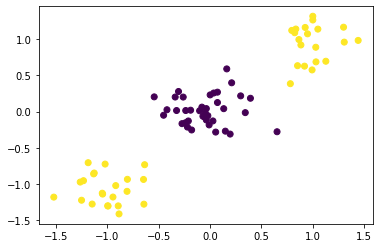

In [4]:
X_train=dataset_train[:,:-1]
y_train=dataset_train[:,2]
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)

b) Viendo este grafico, le parece que los datos son linealmente separables?

c) Haga un cambio de base a 

$\phi_{0} = \mathcal{N}(\mathbf{x} |\vec{\mu}=(-1.0,-1.0),\sigma^{2}=1.0)$

$\phi_{1} = \mathcal{N}(\mathbf{x} | \vec{\mu}=(0.0,0.0),\sigma^{2}=1.0)$

Y grafique los datos en este nuevo espacio. Que puede concluir?

_Ayuda: utilice el metodo pdf para evaluar_

`gauss = multivariate_normal(mean=mean,cov=cov).pdf(X)`

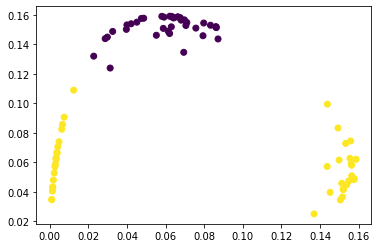

In [6]:
from scipy.stats import multivariate_normal
gauss0=multivariate_normal(mean=[-1.0,-1.0],cov=np.eye(2))
gauss1=multivariate_normal(mean=[0.0,0.0],cov=np.eye(2))
Phi_train=np.hstack((gauss0.pdf(X_train).reshape(-1,1),gauss1.pdf(X_train).reshape(-1,1)))
plt.scatter(Phi_train[:,0],Phi_train[:,1],c=y_train)

d) Entrene un Regresor Logistico en este nuevo espacio, grafique la frontera de decision y calcule la matriz de confusion. Que puede decir al respecto? *Recuerde hacer todo en el nuevo espacio*

### Regresión Logística



En lugar de buscar directamente la función discriminadora podemos tratar de modelar los posterior de nuestro clasificador obteniendo lo que se llama un _modelo discriminador probabilistico_. Uno de estos modelos es el de la Regresión Logistica.

En este modelado, que veremos para dos clases posibles, para un dado $\vec{x}$ modelamos la prioridad de que pertenezca a la clase $\mathcal{C}_{1}$ como:

$p(\mathcal{C}_{1}|\vec{x})=\sigma(\vec{w}^{T}\vec{\phi}(\vec{x}))$

Con $p(\mathcal{C}_{2}|\vec{x})=1-p(\mathcal{C}_{1}|\vec{x})$. $\sigma$ es la función sigmoide

$\sigma(a)=\frac{1}{1+e^{-a}}$

Para este modelo, si se tienen $M$ funciones fijas $\phi$, se tienen $M$ parametros ajustables. 

Para un dataset $\vec{x}_{n}$, con $n=1,..,N$, la verosimilitud es

$p(\text{T}|\vec{w})=\prod_{n=1}^{N}y^{t_n}_{n}(1-y_{n})^{1-t_n}$

De manera tal que, maximizando la verosimilitud, podemos definir un algoritmo iterativo para encontrar los $\vec{w}$, el Iterative Reweighted Least Squares o IRLS. Para la regresión logistica, la función de error es la cross-entropy:

$E(\vec{w})=-\sum_{n=1}^{N}(t_{n}\text{ln}y_{n}+(1-t_{n})\text{ln}(1-y_{n}))$

Para minimizar este error, el algoritmo utiliza una actualización de Newton-Ralphson:

$\vec{w}^{\text{nuevo}}=\vec{w}^{\text{viejo}}-\text{H}^{-1}\nabla E(\vec{w})$

Donde $\nabla E(\vec{w})$ es el gradiente del error y $\text{H}$ es la matriz Hessiana. Para la regresion logistica, uno puede llegar a sus propias ecuaciones normales _iterativas_

$\vec{w}^{\text{nuevo}}=(\text{$\Phi$}^{T}\text{R}\text{$\Phi$})^{-1}\text{$\Phi$}^{T}\text{R}\text{z}$

Con $\Phi$ la matriz de disenio, $\text{R}$ la matriz diagonal cuyos elementos son $y_{n}(1-y_{n})$ y $\text{z}$ es un vector que se calcula como:

$\text{z}=\text{$\Phi$}\vec{w}^{\text{viejo}}-\text{R}^{-1}(\text{Y}-\text{T})$

Con $\text{Y}$ e $\text{T}$ los vectores de predicciones y respuestas respectivamente. Noten que los pesos entran varias veces: en la matriz $\text{R}$, en el vector $\text{Y}$ y explicitamente en $\text{z}$. Es por esto que es iterativo.


Este algoritmo también puede aplicarse al caso de regresión lineal, viendo que el algoritmo de Newton-Raphson converge a la solución cerrada en 1 paso. La diferencia aquí es la función de activación sigmoide. Además, quiero enfatizar que este algoritmo es iterativo pero no es secuencial, ya que utiliza todos los datos del dataset.

### Ejemplo de la funcion sigmoide:

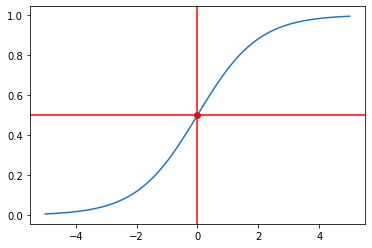

In [13]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
xx = np.linspace(-5,5,100)
plt.plot(xx,list(map(lambda x: sigmoid(x), xx)))
plt.scatter(0.0,sigmoid(0.0),color='red')
plt.axvline(x=0.0,color='red')
plt.axhline(y=0.5,color='red')

Defino la matriz con la columna de unos.

In [15]:
Full_Phi_train=np.hstack((np.ones(Phi_train.shape[0]).reshape(-1,1),Phi_train))
print(Full_Phi_train.shape)

(80, 3)


array([[1.        , 0.15482337, 0.047359  ]])

In [61]:
w=[np.ones(3).reshape(-1,1)]
n_iter = 4
for i in range(n_iter):
  y = np.asarray(list(map(lambda x: sigmoid(np.dot(x,w[-1])),Full_Phi_train)))
  R=np.diag(list(map(lambda yy: yy*(1-yy), y)))
  #print(R.shape)
  #print(y.shape)
  aux_matrix=np.linalg.solve(R,(y-y_train).reshape(-1,1))
  #print(aux_matrix.shape)
  z = np.dot(Full_Phi_train,w[-1])-aux_matrix
  #print(z.shape)
  aux_matrix_2 = np.dot(np.dot(Full_Phi_train.T,R),Full_Phi_train)
  aux_matrix_3 = np.dot(np.dot(Full_Phi_train.T,R),z)
  w_aux=np.linalg.solve(aux_matrix_2,aux_matrix_3)
  #print(w_aux.shape)
  #print(w_aux)
  w.append(w_aux)

In [62]:
W=w[-1][:,0]
y_pred=np.where(y>=0.5,1,0)
print(y_pred.shape)

(80,)


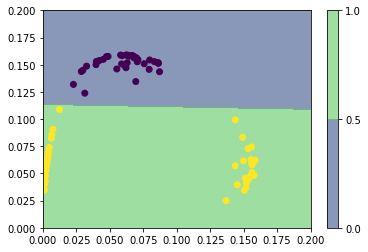

In [69]:
x=np.linspace(0.0,0.2,100)
y=np.linspace(0.0,0.2,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(0.0,0.2)
plt.ylim(0.0,0.2)
Z=(np.asarray([sigmoid(np.dot(W,[1.0,el[0],el[1]])) for el in np.c_[Xtoplot.ravel(), Ytoplot.ravel()]])).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0],alpha=0.6)
plt.colorbar()
plt.scatter(Phi_train[:,0],Phi_train[:,1],c=y_train)

In [64]:
from sklearn.metrics import confusion_matrix

cf=confusion_matrix(y_train,y_pred)
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[38  0]
 [ 0 42]]
Sensitividad (TPR/Recall):   1.000
Especificidad:   1.000
Precision:   1.000
FPR:   0.000


e) Grafique la frontera de decision en el espacio original. Que concluye?

_Ayuda: Lo que uno tiene que hacer es un contour plot de la funcion de decision en el espacio original. Es decir, $F(\phi_{0}(x_{1},x_{2}),\phi_{1}(x_{1},x_{2}))$. La manera mas facil de hacerlo es crear un array que traduzca tus coordenadas al espacio $\phi_{0}, \phi_{1}$ y evaluar ahi:_



```
x1=...
x2=...
X1,X2 = np.meshgrid(x1,x2)
transformed_array=np.asarray([[phi0(ele),phi1(ele)] for ele in np.c_[X1.ravel(), X2.ravel()]])
Z=model.decision_function(transformed_array)
```






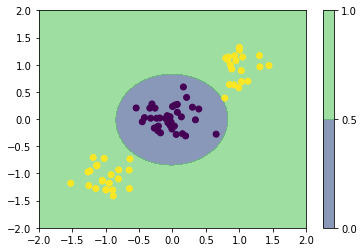

In [68]:
x=np.linspace(-2.0,2.0,100)
y=np.linspace(-2.0,2.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)
Z=(np.asarray([sigmoid(np.dot(W,[1.0,gauss0.pdf(el),gauss1.pdf(el)])) for el in np.c_[Xtoplot.ravel(), Ytoplot.ravel()]])).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0],alpha=0.6)
plt.colorbar()
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)

## Sensibilidad a outliers

Al ser un modelo discriminativo, los outliers o anomalias son menos problematicas.

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


Si no hay anomalias

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


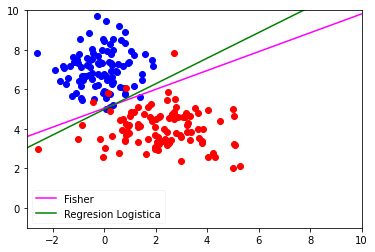

In [103]:
np.random.seed(42)
X1=multivariate_normal.rvs(size=100,mean=[0,7],cov=[[1,0.0],[0.0, 1]])
X2=multivariate_normal.rvs(size=100,mean=[2,4],cov=[[2,0.0],[0.0, 1]])
plt.scatter(X1[:,0],X1[:,1],color='blue')
plt.scatter(X2[:,0],X2[:,1],color='red')
X=np.vstack((X1,X2))
t=np.vstack((np.ones(X1.shape[0]).reshape(-1,1),np.zeros(X2.shape[0]).reshape(-1,1)))
lda=LinearDiscriminantAnalysis(solver='eigen')
lr=LogisticRegression()
lda.fit(X,t)
lr.fit(X,t)

intercept_lda=lda.intercept_
coeffs_lda=lda.coef_[0]

intercept_lr=lr.intercept_
coeffs_lr=lr.coef_[0]

x=np.linspace(-3.0,10.0,100)
y=np.linspace(-1.0,10.0,100)
lda_boundary=-(intercept_lda+coeffs_lda[0]*x)/coeffs_lda[1]
lr_boundary=-(intercept_lr+coeffs_lr[0]*x)/coeffs_lr[1]

plt.plot(x,lda_boundary,color='magenta',label='Fisher')
plt.plot(x,lr_boundary,color='green',label='Regresion Logistica')
#plt.contour(Xtoplot,Ytoplot,Z,levels=[-1.0,0.0,1.0],color='magenta',alpha=1.0)
plt.xlim((-3,10))
plt.ylim((-1,10))
plt.legend(loc='lower left',framealpha=0.2)

In [104]:
cf=confusion_matrix(t,lda.predict(X))
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[96  4]
 [ 4 96]]
Sensitividad (TPR/Recall):   0.960
Especificidad:   0.960
Precision:   0.960
FPR:   0.040


In [105]:
cf=confusion_matrix(t,lr.predict(X))
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[96  4]
 [ 4 96]]
Sensitividad (TPR/Recall):   0.960
Especificidad:   0.960
Precision:   0.960
FPR:   0.040


Con anomalias:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


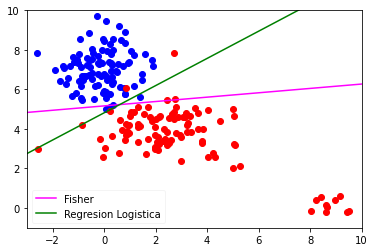

In [106]:
np.random.seed(42)
X1=multivariate_normal.rvs(size=100,mean=[0,7],cov=[[1,0.0],[0.0, 1]])
aux1=multivariate_normal.rvs(size=90,mean=[2,4],cov=[[2,0.0],[0.0, 1]])
aux2=multivariate_normal.rvs(size=10,mean=[9,0],cov=[[0.2,0.0],[0.0, 0.1]])
X2=np.zeros(X1.shape)
X2[:,0]=np.append(aux1[:,0],aux2[:,0])
X2[:,1]=np.append(aux1[:,1],aux2[:,1])
plt.scatter(X1[:,0],X1[:,1],color='blue')
plt.scatter(X2[:,0],X2[:,1],color='red')
X=np.vstack((X1,X2))
t=np.vstack((np.ones(X1.shape[0]).reshape(-1,1),np.zeros(X2.shape[0]).reshape(-1,1)))
lda=LinearDiscriminantAnalysis(solver='eigen')
lr=LogisticRegression()
lda.fit(X,t)
lr.fit(X,t)

intercept_lda=lda.intercept_
coeffs_lda=lda.coef_[0]

intercept_lr=lr.intercept_
coeffs_lr=lr.coef_[0]

x=np.linspace(-3.0,10.0,100)
y=np.linspace(-1.0,10.0,100)
lda_boundary=-(intercept_lda+coeffs_lda[0]*x)/coeffs_lda[1]
lr_boundary=-(intercept_lr+coeffs_lr[0]*x)/coeffs_lr[1]

plt.plot(x,lda_boundary,color='magenta',label='Fisher')
plt.plot(x,lr_boundary,color='green',label='Regresion Logistica')
#plt.contour(Xtoplot,Ytoplot,Z,levels=[-1.0,0.0,1.0],color='magenta',alpha=1.0)
plt.xlim((-3,10))
plt.ylim((-1,10))
plt.legend(loc='lower left',framealpha=0.2)

In [107]:
cf=confusion_matrix(t,lda.predict(X))
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[96  4]
 [ 3 97]]
Sensitividad (TPR/Recall):   0.970
Especificidad:   0.960
Precision:   0.960
FPR:   0.040


In [108]:
cf=confusion_matrix(t,lr.predict(X))
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[98  2]
 [ 1 99]]
Sensitividad (TPR/Recall):   0.990
Especificidad:   0.980
Precision:   0.980
FPR:   0.020


## Matriz de perdida:

Cuando uno tiene clases no linealmente separables, no puede clasificar perfectamente y tiene que empezar a decidir que error prefiere minimizar. Aqui entra la matriz de perdida  $L_{kj}$  donde $j$ es la clase a la que se lo asigna.

Es decir, uno asigna la clase $j$ a la medicion $x$ como la que minimiza

$\sum_{k}L_{kj}p(C_{k}|x)$

Volvamos al ejemplo de mas arriba, y decidamos que me importa mas clasificar bien los objetos de la clase 1 que los de la clase 2. Como matriz de perdida, esta seria:

Esto seria

In [110]:
Loss=np.array([[0.0,1000.0],[1.0,0.0]])
print(Loss)

[[   0. 1000.]
 [   1.    0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'color'


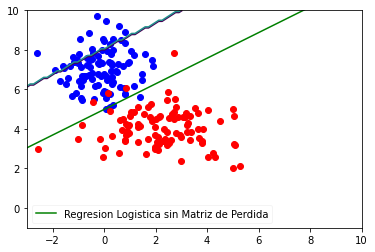

In [145]:
np.random.seed(42)
X1=multivariate_normal.rvs(size=100,mean=[0,7],cov=[[1,0.0],[0.0, 1]])
X2=multivariate_normal.rvs(size=100,mean=[2,4],cov=[[2,0.0],[0.0, 1]])
plt.scatter(X1[:,0],X1[:,1],color='blue')
plt.scatter(X2[:,0],X2[:,1],color='red')
X=np.vstack((X1,X2))
t=np.vstack((np.ones(X1.shape[0]).reshape(-1,1),np.zeros(X2.shape[0]).reshape(-1,1)))

lr=LogisticRegression()
lr.fit(X,t)

intercept_lr=lr.intercept_
coeffs_lr=lr.coef_[0]

x=np.linspace(-3.0,10.0,100)
y=np.linspace(-1.0,10.0,100)
Xtoplot, Ytoplot = np.meshgrid(x,y)

lr_probas=lr.predict_proba(np.c_[Xtoplot.ravel(), Ytoplot.ravel()])
t_pred_aux=np.asarray(list(map(lambda pp: [Loss[1,0]*pp[1],Loss[0,1]*pp[0]],lr_probas)))
t_pred=np.where(t_pred_aux[:,0]>=t_pred_aux[:,1],1.0,0.0).reshape(Xtoplot.shape)

lr_boundary=-(intercept_lr+coeffs_lr[0]*x)/coeffs_lr[1]

plt.plot(x,lr_boundary,color='green',label='Regresion Logistica sin Matriz de Perdida')
plt.contour(Xtoplot,Ytoplot,t_pred,levels=[0.0,0.5,1.0],color='magenta',alpha=1.0)
plt.xlim((-3,10))
plt.ylim((-1,10))
plt.legend(loc='lower left',framealpha=0.2)

In [139]:
max(t_pred[:,0])

1.0

In [114]:
cf=confusion_matrix(t,lr.predict(X))
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[96  4]
 [ 4 96]]
Sensitividad (TPR/Recall):   0.960
Especificidad:   0.960
Precision:   0.960
FPR:   0.040


In [119]:
lr_probas=lr.predict_proba(X)
t_pred_aux=np.asarray(list(map(lambda pp: [Loss[1,0]*pp[1],Loss[0,1]*pp[0]],lr_probas)))
t_pred=np.where(t_pred_aux[:,0]>=t_pred_aux[:,1],1.0,0.0)
cf=confusion_matrix(t,t_pred)
print(cf)
tn, fp, fn, tp = cf.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[100   0]
 [ 79  21]]
Sensitividad (TPR/Recall):   0.210
Especificidad:   1.000
Precision:   1.000
FPR:   0.000


Otra opcion es, a la hora de entrenar, darle mas peso a una clase que a la otra. Esto se puede lograr con la opcion de `class_weight`. Corresponde a dar mas peso a un acierto que a otro, pero no da penalidades a distintos errores.

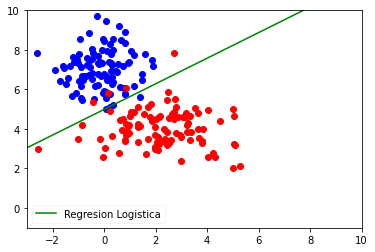

In [125]:
plt.scatter(X1[:,0],X1[:,1],color='blue')
plt.scatter(X2[:,0],X2[:,1],color='red')

lr=LogisticRegression(class_weight=[100,0])
lr.fit(X,t[:,0])

intercept_lr=lr.intercept_
coeffs_lr=lr.coef_[0]

x=np.linspace(-3.0,10.0,100)
y=np.linspace(-1.0,10.0,100)

lr_boundary=-(intercept_lr+coeffs_lr[0]*x)/coeffs_lr[1]

plt.plot(x,lr_boundary,color='green',label='Regresion Logistica')
#plt.contour(Xtoplot,Ytoplot,Z,levels=[-1.0,0.0,1.0],color='magenta',alpha=1.0)
plt.xlim((-3,10))
plt.ylim((-1,10))
plt.legend(loc='lower left',framealpha=0.2)